In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostRegressor

In [9]:
# Load the dataset
file_path = 'filtered_data.csv'
data = pd.read_csv(file_path)
data_head = data.head()
data_description = data.describe()
data_info = data.info()

(data_head, data_description, data_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57122 entries, 0 to 57121
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         57122 non-null  int64  
 1   seller             57122 non-null  object 
 2   offerType          57122 non-null  object 
 3   abtest             57122 non-null  object 
 4   vehicleType        57122 non-null  object 
 5   gearbox            57122 non-null  object 
 6   model              57122 non-null  object 
 7   fuelType           57122 non-null  object 
 8   brand              57122 non-null  object 
 9   notRepairedDamage  57122 non-null  object 
 10  powerPS_scaled     57122 non-null  float64
 11  kilometer_scaled   57122 non-null  float64
 12  price              57122 non-null  float64
 13  age_of_car_scaled  57122 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 6.1+ MB


(   Unnamed: 0   seller offerType abtest vehicleType    gearbox        model  \
 0           2  private   listing   test   limousine     manual         golf   
 1           7  private   listing   test   limousine     manual       mondeo   
 2          11  private   listing   test         bus     manual  transporter   
 3          13  private   listing   test       kombi     manual       passat   
 4          14  private   listing   test       kombi  automatic       signum   
 
   fuelType       brand notRepairedDamage  powerPS_scaled  kilometer_scaled  \
 0   diesel  volkswagen                no        0.352941          1.000000   
 1   diesel        ford                no        0.549020          1.000000   
 2   diesel  volkswagen                no        0.513725          0.583333   
 3   diesel  volkswagen                no        0.549020          1.000000   
 4   diesel        opel                no        0.588235          0.583333   
 
      price  age_of_car_scaled  
 0   4500

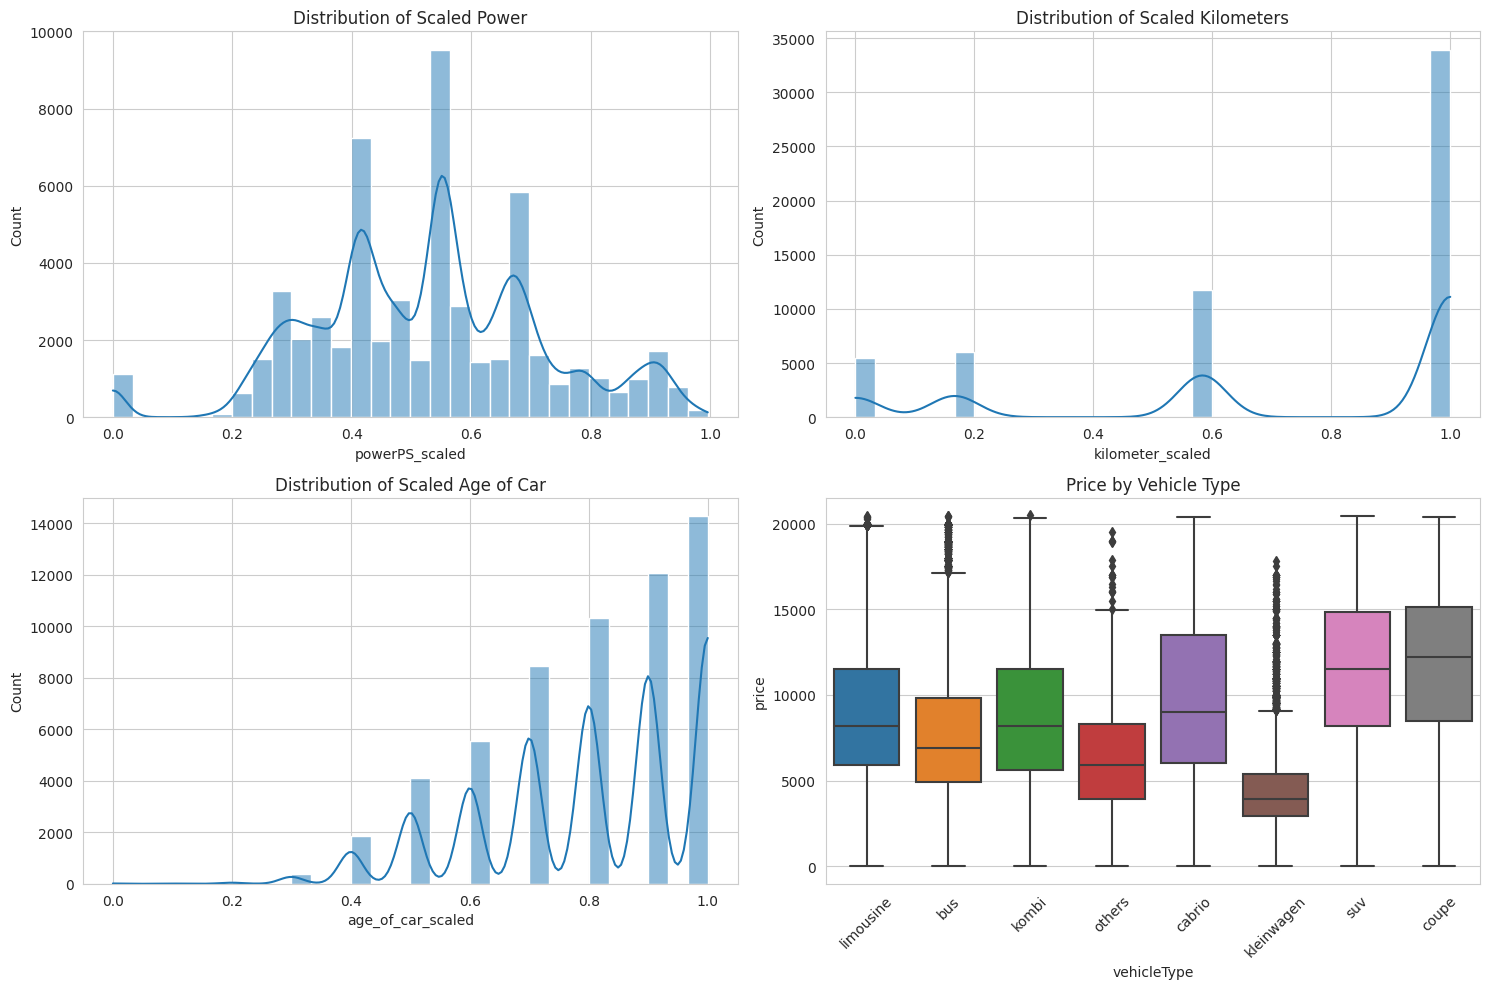

In [10]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Histograms for continuous features
sns.histplot(data['powerPS_scaled'], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Scaled Power')
sns.histplot(data['kilometer_scaled'], bins=30, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Scaled Kilometers')
sns.histplot(data['age_of_car_scaled'], bins=30, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Scaled Age of Car')

# Boxplot for price against vehicle type
sns.boxplot(x='vehicleType', y='price', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Price by Vehicle Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The scaled power of the vehicles tends to cluster around 0.4 to 0.7, with a fairly normal distribution. This suggests that most vehicles have a moderate amount of power, with few very low or very high-power vehicles.

The scaled kilometer reading shows that a large number of vehicles have high kilometer readings, as indicated by the peak around 1.0. This suggests that used vehicles with higher mileage are common in the dataset.

The scaled age of the car is slightly left-skewed, indicating that there are more newer used cars than older ones in the dataset, with peaks around 0.7 to 0.9.

The boxplot for price by vehicle type indicates that there is variation in price across different types of vehicles. Some vehicle types, like limousine, have a higher median price and also show a wide range of prices.

Given these distributions and the presence of categorical variables that may have complex relationships with the price, models that can handle both nonlinear relationships and interactions between features might perform well. Ensemble methods like GradientBoostingRegressor or ExtraTreesRegressor are capable of capturing these complex relationships, especially if they are tuned properly.

Encoding categorical variables using one-hot encoding since most machine learning models require numerical input.
Splitting the data into features (X) and target (y), which in this case is the price.
Splitting the dataset into training and testing sets to be able to evaluate the performance of our models.

In [11]:
# Dropping the 'Unnamed: 0' column as it is an index column
data.drop('Unnamed: 0', axis=1, inplace=True)

# One-hot encode the categorical variables
categorical_features = ['seller', 'offerType', 'abtest', 'vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
data_encoded = pd.get_dummies(data, columns=categorical_features)
X = data_encoded.drop('price', axis=1)
y = data_encoded['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **GRADIENT BOOSTING REGRESSOR**
We will first train the GradientBoostingRegressor. After evaluating their performance with these default settings, we can decide if hyperparameter tuning is necessary.

In [11]:

# Initialize the models with default parameters
gb_regressor = GradientBoostingRegressor(random_state=42)

# Train the Gradient Boosting Regressor
gb_regressor.fit(X_train, y_train)
# Predict on the test set
gb_predictions = gb_regressor.predict(X_test)
# Evaluate the model
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

# Print the performance metrics
print(f'GradientBoostingRegressor without tuning Mean Squared Error: {gb_mse}')
print(f'Gradient Boosting Regressor without tuning R^2 Score: {gb_r2}')

GradientBoostingRegressor without tuning Mean Squared Error: 4926008.927793037
Gradient Boosting Regressor without tuning R^2 Score: 0.7433318172773486


# **HYPERPARAMETER TUNING OF GRADIENT BOOSTING USING RANDOMIZEDSEARCHCV**

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': range(100, 1100, 100),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': range(3, 14, 2),
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
best_score = -random_search.best_score_

(best_params, best_score)


({'subsample': 0.9,
  'n_estimators': 800,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_depth': 7,
  'learning_rate': 0.1},
 3730064.290505567)

# *TUNED GRADIENT BOOSTING REGRESSOR*

Now we will use the parameters we got from the RandomizedSearch above and use it for better results

In [15]:


# Initialize the GradientBoostingRegressor model with the best parameters
best_gbr_model = GradientBoostingRegressor(
    subsample=0.9,
    n_estimators=800,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=7,
    learning_rate=0.1,
    random_state=42
)

# Fit the model on the training data
best_gbr_model.fit(X_train, y_train)

# Predict the prices on the test set
y_pred_best_gbr = best_gbr_model.predict(X_test)

# Calculate the mean squared error and the R^2 score for the tuned GradientBoostingRegressor model
mse_best_gbr = mean_squared_error(y_test, y_pred_best_gbr)
r2_best_gbr = r2_score(y_test, y_pred_best_gbr)

print(f'Tuned GradientBoostingRegressor Mean Squared Error: {mse_best_gbr}')
print(f'Tuned GradientBoostingRegressor R^2 Score: {r2_best_gbr}')

Tuned GradientBoostingRegressor Mean Squared Error: 3742550.0554930666
Tuned GradientBoostingRegressor R^2 Score: 0.8049955784545583


# **VISUALIZATION**: *FEATURE IMPORTANCE*

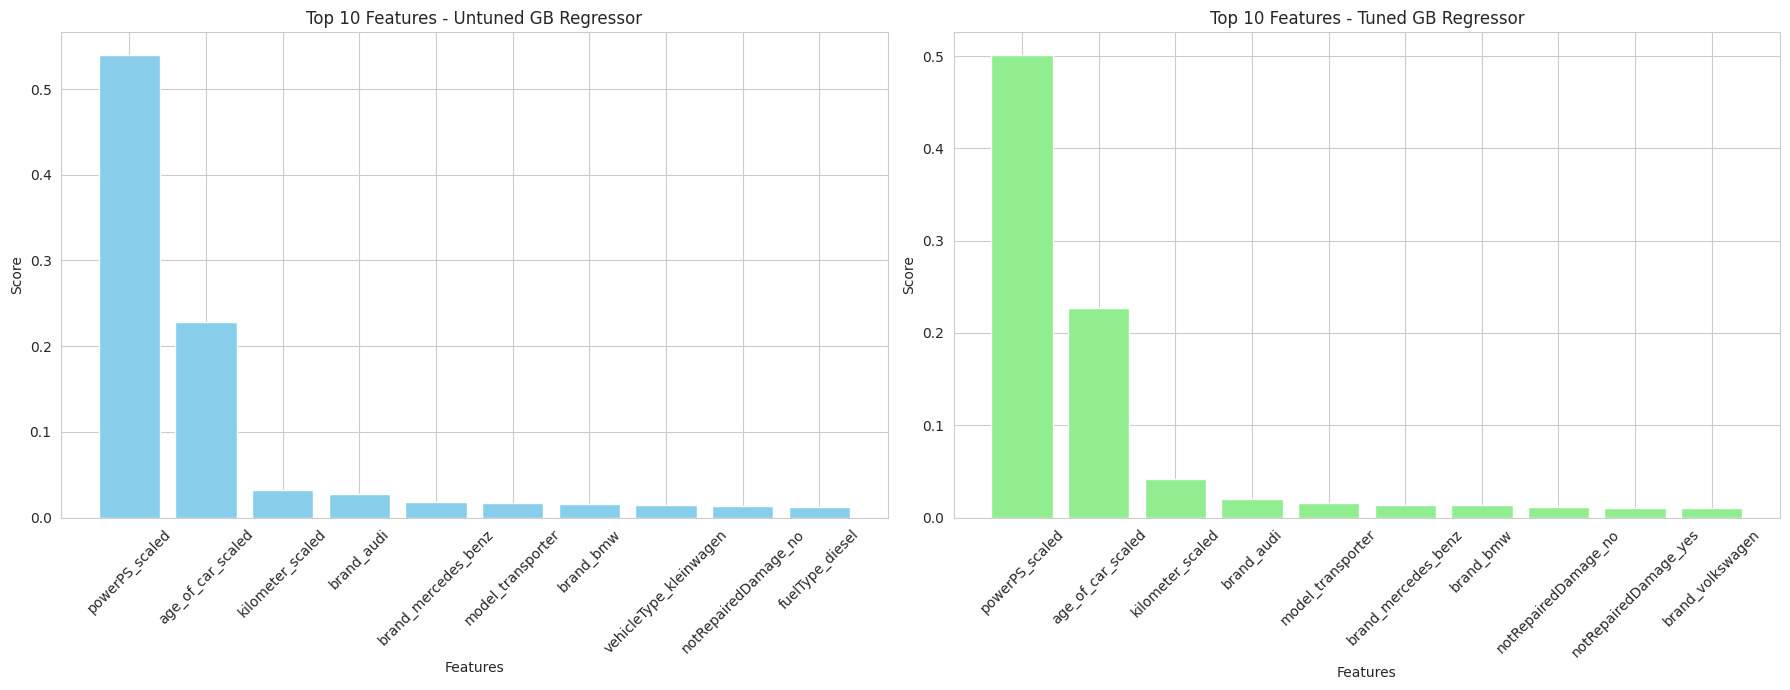

In [20]:
# Extract top 10 feature importances for the untuned model
sorted_index_untuned = np.argsort(feature_importances_untuned)[::-1][:10]
top_features_untuned = feature_importances_untuned[sorted_index_untuned]
top_feature_names_untuned = X_train.columns[sorted_index_untuned]

# Extract top 10 feature importances for the tuned model
sorted_index_tuned = np.argsort(feature_importances_tuned)[::-1][:10]
top_features_tuned = feature_importances_tuned[sorted_index_tuned]
top_feature_names_tuned = X_train.columns[sorted_index_tuned]

# Function to create a bar plot
def create_bar_plot(ax, feature_importances, feature_names, title, bar_color):
    ax.bar(range(len(feature_importances)), feature_importances, align="center", color=bar_color)
    ax.set_xticks(range(len(feature_importances)))
    ax.set_xticklabels(feature_names, rotation=45)
    ax.set_xlabel("Features")
    ax.set_ylabel("Score")
    ax.set_title(title)

# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Plot for untuned model
create_bar_plot(axes[0], top_features_untuned, top_feature_names_untuned, 'Top 10 Features - Untuned GB Regressor', 'skyblue')

# Plot for tuned model
create_bar_plot(axes[1], top_features_tuned, top_feature_names_tuned, 'Top 10 Features - Tuned GB Regressor', 'lightgreen')

plt.tight_layout()
plt.show()


# **VISUALIZATION**: *PREDICTED VS ACTUAL VALUES*

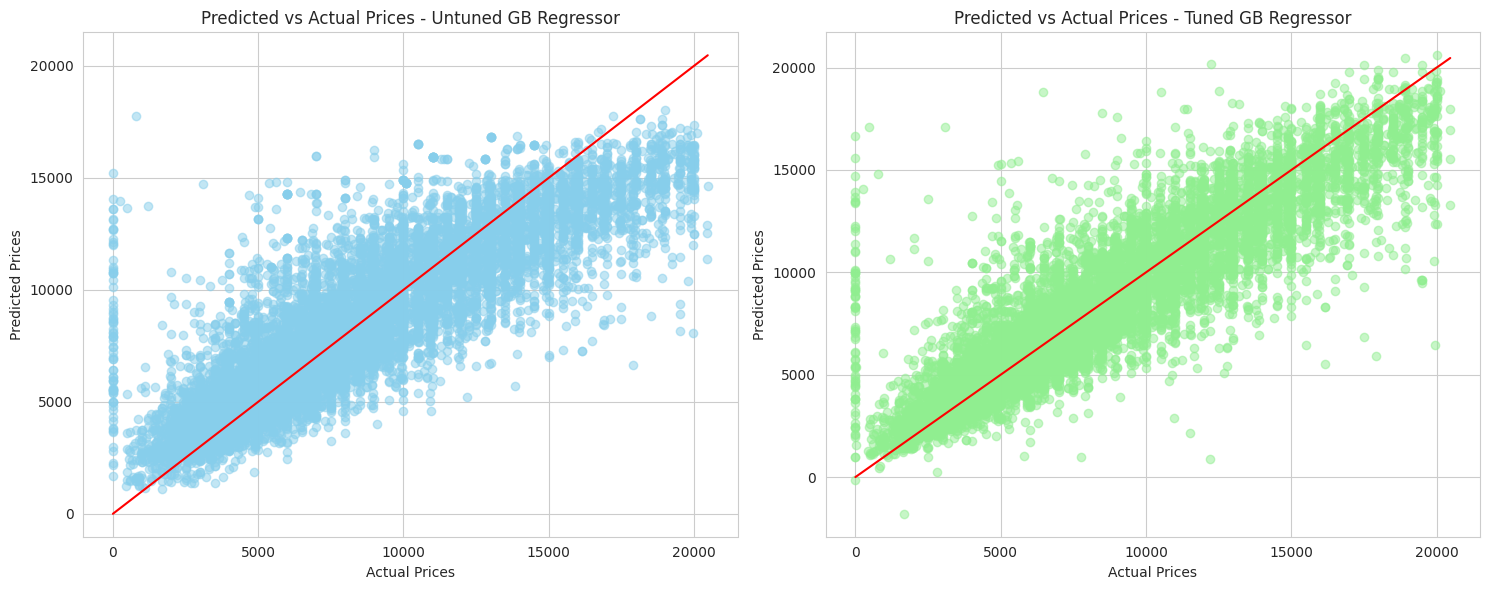

In [22]:
plt.figure(figsize=(15, 6))

#Untuned Model
plt.subplot(1, 2, 1)
plt.scatter(y_test, gb_predictions, alpha=0.5, color='skyblue')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices - Untuned GB Regressor')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

#Tuned Model
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_best_gbr, alpha=0.5, color='lightgreen')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices - Tuned GB Regressor')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.tight_layout()
plt.show()


# **SUPPORT VECTOR REGRESSOR**
Will be performing PCA before SVR as SVR cant be performed on big data set.

In [22]:
# Choosing components with 0.95 as variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# Splitting the reduced data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)
print(f'X_train after PCA: {X_train_pca.shape}')
print(f'X_test after PCA: {X_test_pca.shape}')
print(f'PCA Components:{pca.n_components_}')


X_train after PCA: (45697, 78)
X_test after PCA: (11425, 78)
PCA Components:78


## NOW APPLYING SVR

In [18]:

# Training SVR model on the reduced dataset (PCA applied)
svr_model_pca = SVR(kernel='linear')
svr_model_pca.fit(X_train_pca, y_train_pca)

# Predicting values
y_pred_pca = svr_model_pca.predict(X_test_pca)

# Metrics
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
mae_pca = mean_absolute_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'Mean Squared Error: {mse_pca}')
print(f'Mean Absolute Error: {mae_pca}')
print(f'R2 Score:{r2_pca}')

Mean Squared Error: 8949816.524953583
Mean Absolute Error: 2231.4043291929356
R2 Score:0.5336725578793953


### *HYPERPARAMETER TUNING USING GRIDSEARCHCV TO GET THE BEST PARAMETERS FOR SVR*

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 1],
    'epsilon': [0.1, 0.5],
    'kernel': ['rbf']  }

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid
grid_search.fit(X_train_pca, y_train_pca)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)
best_svr_model = grid_search.best_estimator_


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found:  {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score found:  10304769.465866528


### ***Using the best parameters we got from GridSearchCV and using those parameters for getting better performance***

In [21]:
svr_model_pca_best = SVR(C=10, epsilon=0.1, gamma='scale', kernel='rbf')
svr_model_pca_best.fit(X_train_pca, y_train_pca)
y_pred_pca_best = svr_model_pca_best.predict(X_test_pca)
mse_pca_best = mean_squared_error(y_test_pca, y_pred_pca_best)
mae_pca_best = mean_absolute_error(y_test_pca, y_pred_pca_best)
r2_pca_best = r2_score(y_test_pca, y_pred_pca_best)

# The evaluation metrics
print(f'Mean Squared Error: {mse_pca_best}')
print(f'Mean Absolute Error: {mae_pca_best}')
print(f'R2 Score: {r2_pca_best}')


Mean Squared Error: 9092259.340627458
Mean Absolute Error: 2241.9102586068693
R2 Score: 0.5262506187037204


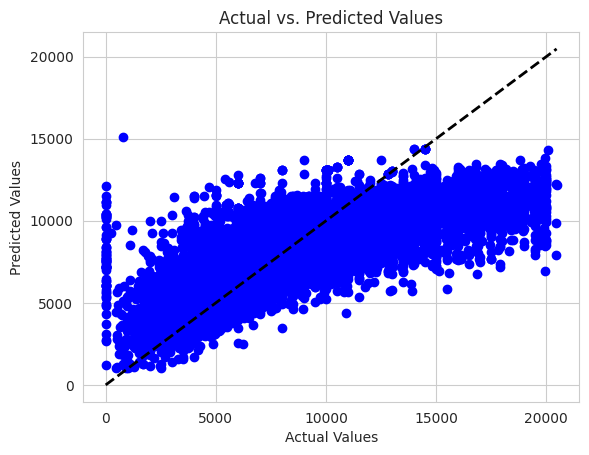

In [26]:
plt.scatter(y_test_pca, y_pred_pca, color='blue')
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()



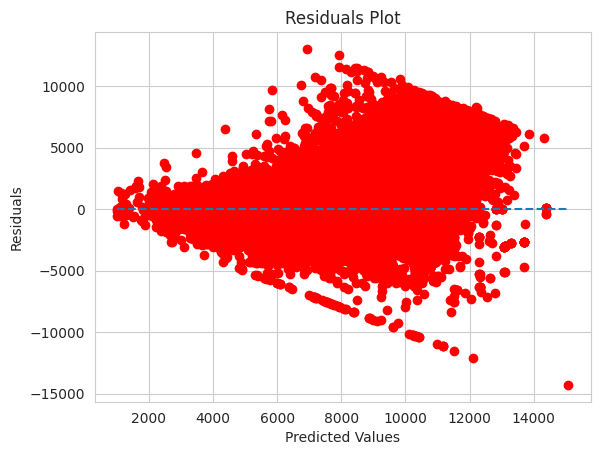

In [27]:
residuals = y_test_pca - y_pred_pca

plt.scatter(y_pred_pca, residuals, color='red')
plt.hlines(y=0, xmin=y_pred_pca.min(), xmax=y_pred_pca.max(), linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')